In [1]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import h5py

sns.set_style('whitegrid')

sns.set_context('notebook')

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 200
sns.set(context='poster',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})
%load_ext autoreload
%autoreload 2

root = '/home/ubuntu/ext_vol'
import sys
sys.path.insert(0, f'{root}/inpca')

from utils import get_data, get_idx, triplot, plotly_3d

In [2]:
import plotly.graph_objects as go
import numpy as np
import plotly.offline as pyo
import pandas as pd
pyo.init_notebook_mode()
from matplotlib.lines import Line2D    
from utils import CDICT_M

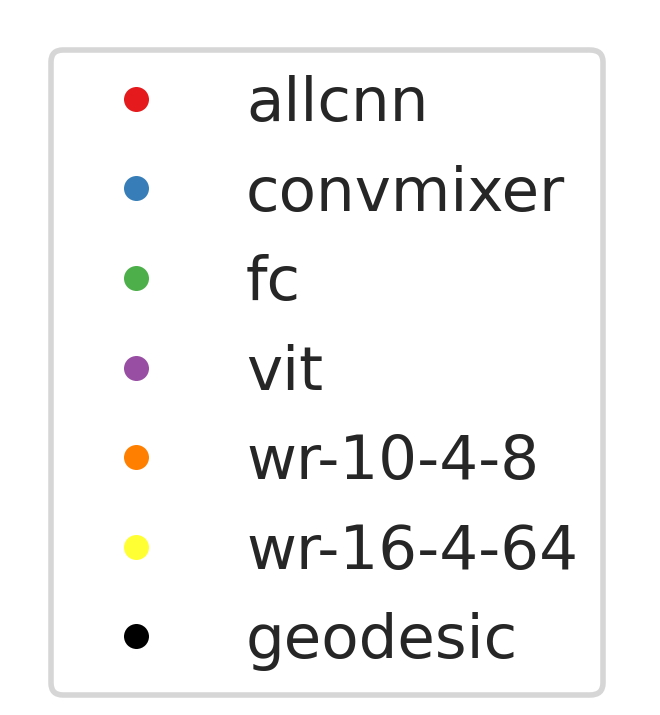

In [3]:
def build_legend(data):
    """
    Build a legend for matplotlib plt from dict
    """
    legend_elements = []
    for key in data:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=key,
                                        markerfacecolor=data[key], markersize=10))
    return legend_elements

fig,ax = plt.subplots(1, figsize=(4,4))
ax.axis('off')
legend_elements = build_legend(CDICT_M)
ax.legend(handles=legend_elements, loc='upper left')
fig.savefig('plots/legends.pdf')  

### Plots in Paper

In [103]:
key = 'yh'
fn = 'all_geod'
r = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/r_{key}_{fn}.p")
# didx = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p').reset_index(drop=False)
if fn != 'all_geod':
    didx = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_{key}_{fn}.p").reset_index(drop=True)
else:
    didx = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p').reset_index(drop=True)

In [72]:
cols = ['seed', 'aug', 'm', 'lr', 'opt', 'bs', 'wd']

In [86]:
# compute length of trajectories
cols = ['seed', 'aug', 'm', 'lr', 'opt', 'bs', 'wd']
for k in ['yh', 'yvh']:
    with h5py.File(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/w_{k}_all_geod.h5", "r") as f:
        w = f["w"]
        for (c, ii) in tqdm.tqdm(didx.groupby(cols).indices.items()):
            didx.loc[ii[1:], f'length_{k}'] = list(np.diag(w[ii, :][:, ii], 1))

100%|███████████████████████████████████████████████████████████████████████████████████| 2297/2297 [06:02<00:00,  6.33it/s]


In [73]:
# normalize length of trajectories by (#updates*lr)^2
for (c, ii) in didx.groupby(cols).indices.items():
    if c[2]=='geodesic':
        continue
    di = didx.iloc[ii]
    lr_t = 0.5*float(di.lr.iloc[0])*(1+np.cos((di.t/di.t.max())*np.pi))
    nsteps = di.iloc[1:].t.values - di.iloc[:-1].t.values
    normalizer = (lr_t[:-1]*nsteps)**2
    didx.loc[ii[1:], 'nsteps'] = nsteps
    didx.loc[ii[1:], 'length_yh_normalized'] = didx.iloc[ii[1:]].length_yh / normalizer
    didx.loc[ii[1:], 'length_yvh_normalized'] = didx.iloc[ii[1:]].length_yvh / normalizer

In [136]:
# digitize train/test progress
bins = np.linspace(0,1,100)
for key in ['lam_yh', 'lam_yvh']:
    ind = np.digitize(didx[key], bins)
    didx[key] = bins[ind-1]

In [4]:
# compute number of neighbors within a radius
import h5py
radius = 0.4
ncount = np.zeros(len(didx))
with h5py.File(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/w_{key}_all_geod.h5", "r") as f:
    w = f["w"]
    for aa in tqdm.tqdm(th.chunk(th.arange(len(didx)), 500)):
        wi = w[list(aa), :]
        ncount[aa] = (wi < radius).sum(-1)
didx['ncount'] = ncount

100%|█████████████████████████████████████████████████████████████████████████████████████| 499/499 [05:38<00:00,  1.47it/s]


In [62]:
# compute end_error of each configuration
cols = ['seed', 'aug', 'm', 'lr', 'opt', 'bs', 'wd']
for (c, ii) in didx.groupby(cols).indices.items():
    didx.loc[ii, 'end_err'] = didx.iloc[ii[-1]].err
    didx.loc[ii, 'end_verr'] = didx.iloc[ii[-1]].verr
# ii = get_idx(didx, "end_err > 0.1")
# didx = didx.drop(ii).reset_index(drop=True)
# r['xp'] = np.delete(r['xp'], ii, 0)

In [80]:
# neighbors of reference points
radius = 0.45
cols = ['seed', 'aug', 'm', 'lr', 'opt', 'bs', 'wd', 'nepochs']
refs = [131546, 128999, 42148, 87937, 132762]
d2ref = []
with h5py.File(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/w_{key}_all_geod.h5", "r") as f:
    w = f["w"]
    for ri in refs:
        d2ref.append(w[ri, :])
d2ref = np.stack(d2ref)
didx['label'] = np.argmin(d2ref, axis=0).astype(str)
didx.loc[np.where(d2ref.min(axis=0) > radius)[0], 'label'] = 'none'
for i in range(len(refs)):
    iid = list(didx[didx.label==str(i)].index)
    didx.loc[iid, 'd2ref'] = d2ref[i, iid]

#### Generic

In [104]:
ii = list(didx[didx.m.isin(['wr-10-4-8', 'wr-16-4-64'])].index)
didx = didx.iloc[ii].reset_index()
r['xp'] = r['xp'][ii, :]

In [105]:
didx.nepochs = didx.nepochs/200

In [122]:
import matplotlib.colors as mc
from functools import partial
rgbc = didx.m.map(CDICT_M)
cc = np.stack(rgbc.map(mc.to_rgb))
# cc[:, -1] = didx.nepochs.values
cc = np.hstack([cc, didx.nepochs.values[:, None]**2])
didx['color'] = [tuple(c) for c in cc]
# didx['color'] = didx['color'].map(partial(mc.to_hex, keep_alpha=True))

In [ ]:
didx = didx.reset_index(drop=True)
# emph = list(didx[didx.m=='geodesic'].index)
# emph = {f'ref{i}':[ r] for (i, r) in enumerate(refs)}
# emp_sizes = {f'ref{i}': 8 for i in range(len(refs))}
# emp_color = {f'ref{i}': 'red' for i in range(len(refs))}
# emph.update({'geodesic':list(didx[didx.m=='geodesic'].index)})
# emp_color.update({'geodesic':'black'})
# didx['nepochs'] = np.clip(didx.nepochs/200,0.2,1)
fig = plotly_3d(dc=didx, r=r, 
#                     emph={'geodesic':emph, 'p0':emph[:1], 'p*':emph[-1:]},
#                     empsize={'geodesic':6, 'p0':8, 'p*':8, 'ref':8}, 
#                     empcolor={'geodesic':'black', 'p0':'red', 'p*':'red', 'ref':'red'},
#                 emph=emph,
#                 empsize=emp_sizes,
#                 empcolor=emp_color,
#                     opacity=0.65,
                    ne=5, 
                    color='color',
#                 discrete_c=False,
#                     colorscale='RdBu_r',
                    cols = ['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'd2truth_yh',
                            'nepochs', 'lr', 'wd', 'vfavg',],
                    xrange=[-1,2],
                    yrange=[-1, 1],
                    zrange=[-0.75, 0.75],
#                  cdict={'wr-10-4-8':'#e41a1c', 'wr-16-4-64':'#377eb8'},
               )
camera = dict(
    up=dict(x=0.25, y=-0.1, z=1),
    center=dict(x=0, y=0.0, z=-0.4),
    eye=dict(x=1.75, y=-0.65, z=1.25)
)
fig.update_layout(scene_camera=camera)
fig.show()

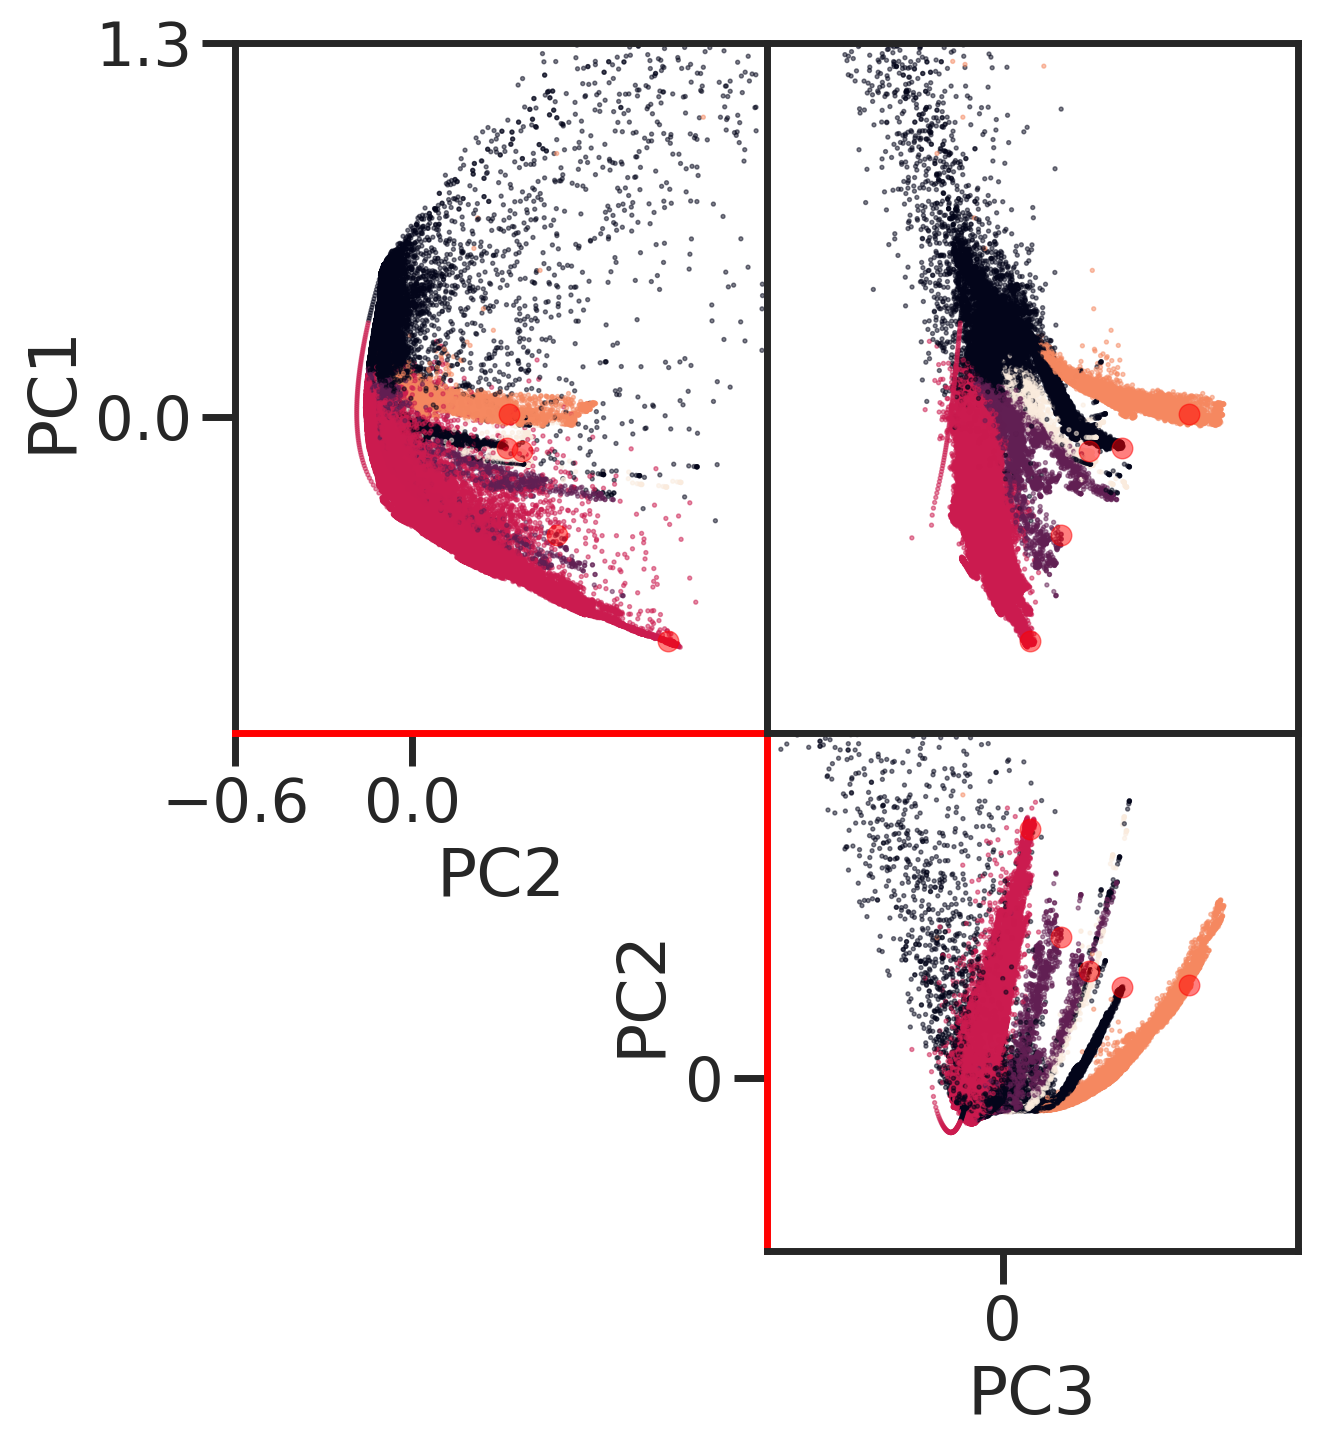

In [64]:
# emph = list(didx[didx.m=='geodesic'].index)
emph = {f'ref{i}':[ r] for (i, r) in enumerate(refs)}
emp_sizes = {f'ref{i}': 55 for i in range(len(refs))}
emp_color = {f'ref{i}': 'red' for i in range(len(refs))}
# emph.update({'geodesic':list(didx[didx.m=='geodesic'].index)})
# emp_color.update({'geodesic':'black'})
f, gs = triplot(didx, r, 
#                 emph={'geodesic':emph, 'p0':emph[:1], 'p*':emph[-1:]},
#                     empsize={'geodesic':6, 'p0':55, 'p*':55, 'ref':8},
#                     empcolor={'geodesic':'black', 'p0':'red', 'p*':'red', 'ref':'red'}, 
                                emph=emph,
                empsize=emp_sizes,
                empcolor=emp_color,
#                 cmin=0, cmax=2,
#                 cdict=CDICT_M,
#                  ckey='label', 
                colorscale='vlag',
                ckey='verr',
                legend=False, 
#                 cbar_title='test loss',
                discrete_c=True, cbins=10,
                grid_ratio=[4, 3, 3], grid_size=0.3,
                flip_dims=[0, 2],
                centers=[0.1, 0.3, 0.1],
#                 grid_ratio=[3, 3], grid_size=0.8,
#                 centers=[0.7,2],
                
               )

In [69]:
[didx[didx.label==str(i)].d2ref.max() for i in range(5)]

[7.277705669403076,
 2.055555820465088,
 1.2966967821121216,
 1.0785945653915405,
 8.127936363220215]

In [82]:
didx.iloc[refs][cols+['err', 'verr']]

seed     aug          m      lr   opt    bs   wd  nepochs      err  \
131546    50  simple         fc     0.5  sgdn  1000  0.0    300.0  0.02264   
128999    50  simple  convmixer   0.005  adam  1000  0.0    200.0  0.00006   
42148     44  simple        vit  0.0005  adam   200  0.0    200.0  0.00054   
87937     47    none        vit    0.25   sgd   500  0.0    200.0  0.00000   
132762    50    none         fc  0.0025  adam  1000  0.0    200.0  0.00000   

          verr  
131546  0.3928  
128999  0.0974  
42148   0.2424  
87937   0.3896  
132762  0.4251

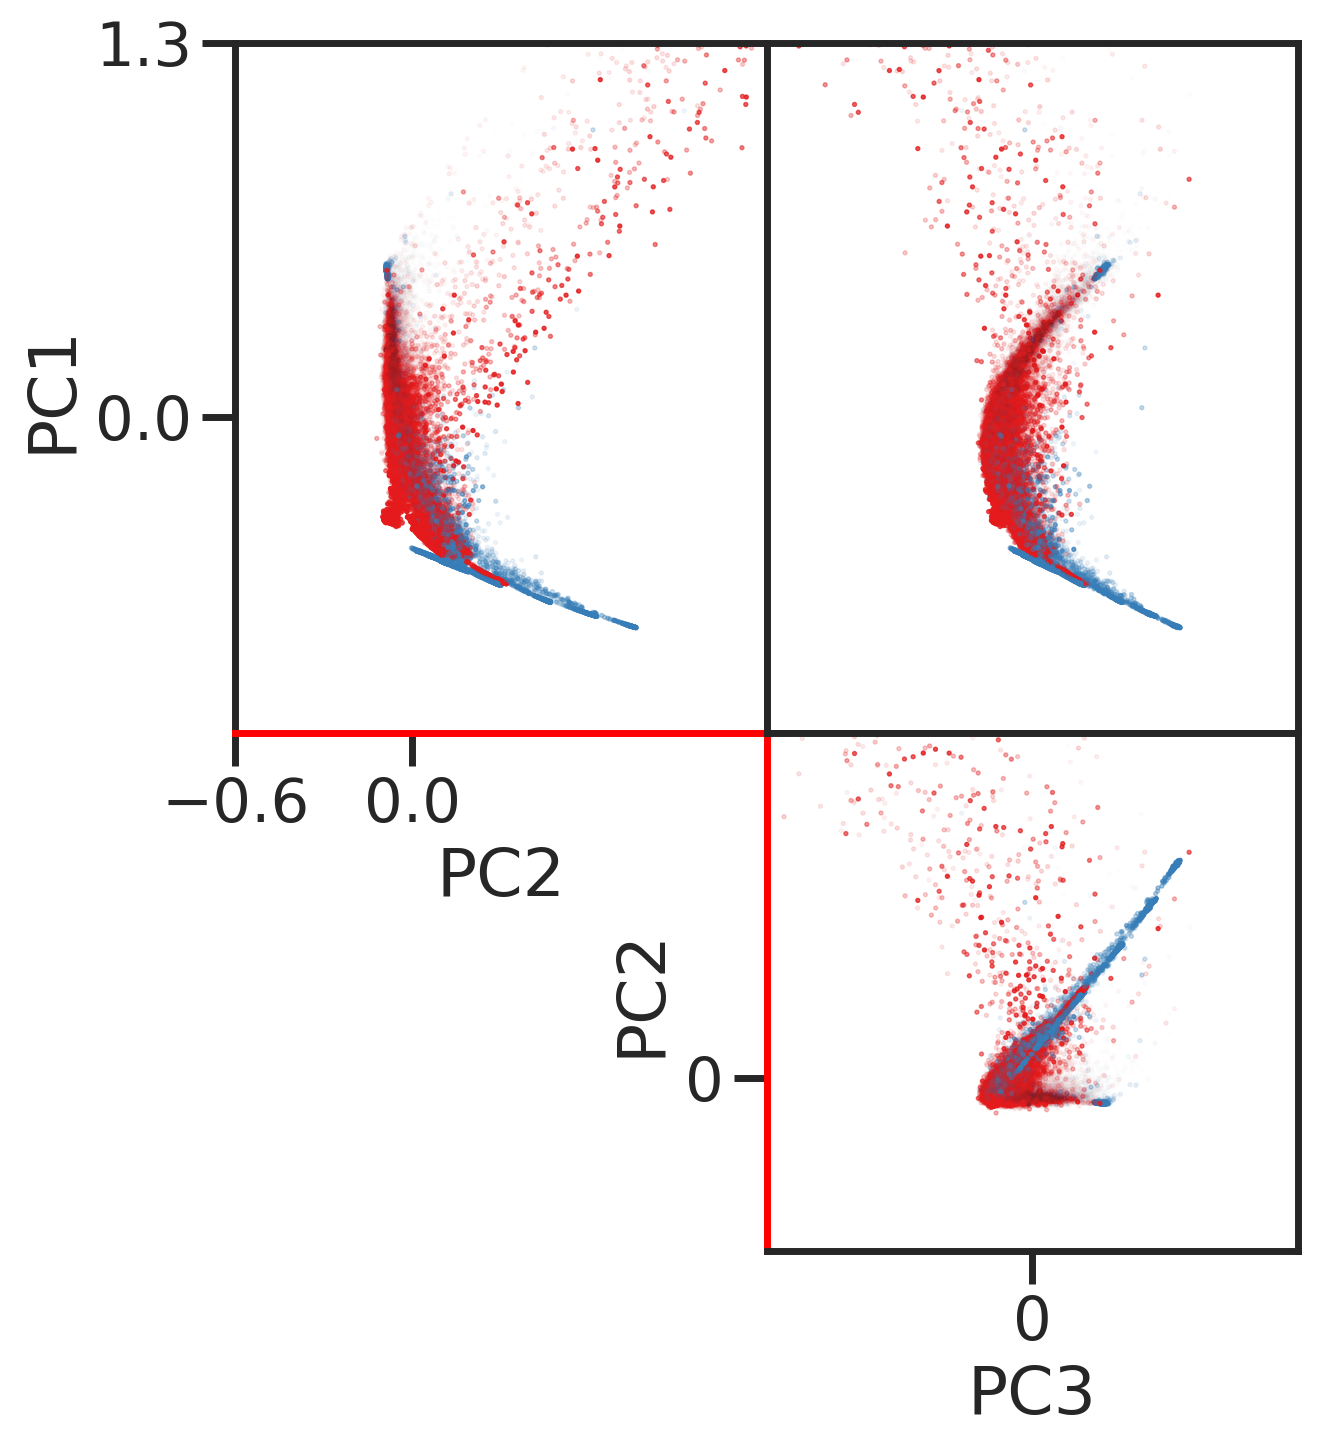

In [101]:
# emph = list(didx[didx.m=='geodesic'].index)
# emph = {f'ref{i}':[ r] for (i, r) in enumerate(refs)}
# emp_sizes = {f'ref{i}': 55 for i in range(len(refs))}
# emp_color = {f'ref{i}': 'red' for i in range(len(refs))}
f, gs = triplot(didx, r, 
#                 emph=emph,
#                     empsize=emp_sizes, ax_label=False,
#                     empcolor=emp_color, 
#                 cmin=0, cmax=1,
#                 cdict=CDICT_M,
                 ckey='color', 
#                 colorscale='rocket',
                legend=False, 
#                 cbar_title='test error',
                discrete_c=False, 
                grid_ratio=[4, 3, 3], grid_size=0.3,
                centers=[0.1, 0.3, 0],
#                 grid_ratio=[3, 3], grid_size=0.3, 
#                 centers=[0, 0.3],
                
               )

In [139]:
f.savefig('plots/all_models_train_2d_ps.pdf', bbox_inches='tight')

In [8]:
from utils import plot_explained_var, plot_evals

In [ ]:
df = pd.DataFrame()
for key in ['yh', 'yvh']:
    r = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/r_{key}_all_geod.p")
    ii = np.argsort(np.abs(r['es']))[::-1]
    es = r['es'][ii][:50]
    dset = 'train' if key == 'yh' else 'test'
    df = pd.concat([df, pd.DataFrame({'eigenvalue index':np.arange(len(es)), 'explained stress':1 - np.sqrt(1-np.cumsum(es ** 2)/r['fn']), 
                       'data':dset})])
f = plt.figure(figsize=(8, 6))
g = sns.lineplot(data=df.reset_index(drop=True), x='eigenvalue index',
             y='explained stress', hue='data', marker="o")


In [40]:
f.savefig('plots/2d_no_fcvit.pdf', bbox_inches='tight')

#### Train

In [ ]:
emph = list(didx[didx.m=='geodesic'].index)
fig = plotly_3d(dc=didx.reset_index(drop=True), r=r, 
                    emph={'geodesic':emph, 'p0':emph[:1], 'p*':emph[-1:]},
                    empsize={'geodesic':6, 'p0':8, 'p*':8}, 
                    empcolor={'geodesic':'black', 'p0':'red', 'p*':'red'},
                    opacity=0.25,
                    colorscale='Set1',
                    ne=5, 
                    color='m',
                    cols = ['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
                    xrange=[-1, 1],
                    yrange=[-0.75, 1.25],
                    zrange=[-0.75, 0.5],
                 cdict=CDICT_M,
#                  xrange=[-2, 3],
#                     yrange=[-0.75, 7],
#                     zrange=[-2, 3]
               )
# fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.5))
camera = dict(
    up=dict(x=0.25, y=-0.1, z=1),
    center=dict(x=0, y=0.0, z=-0.4),
    eye=dict(x=1.75, y=-0.65, z=1.25)
)
fig.update_layout(scene_camera=camera, showlegend=False)
fig.show()

In [ ]:
emph = list(didx[didx.m=='geodesic'].index)
f, gs = triplot(didx.reset_index(drop=True), r, emph={'geodesic':emph, 'p0':emph[:1], 'p*':emph[-1:]},
                    empsize={'geodesic':6, 'p0':8, 'p*':8}, 
                    empcolor={'geodesic':'black', 'p0':'red', 'p*':'red'},
                     ckey='m', colorscale='Set1',
                grid_ratio=[4,3,3], grid_size=0.3,
                centers=[0,0.2,0])

#### Test

In [ ]:
emph = list(didx[didx.m=='geodesic'].index)
cmap = {f"m: {c}": i for (i, c) in enumerate(didx.m.unique())} 
fig = plotly_3d(dc=didx.reset_index(drop=True), r=r, 
                    emph={'geodesic':emph, 'p0':emph[:1], 'p*':emph[-1:]},
                    empsize={'geodesic':4, 'p0':8, 'p*':8}, 
                    empcolor={'geodesic':'black', 'p0':'red', 'p*':'red'},
                    opacity=0.25,
                    cdict=CDICT_M,
                    ne=5, 
                    size=2,
                    color='m',
                    cols = ['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
                    xrange=[-1, 1],
                    yrange=[-0.5, 1.5],
                    zrange=[-0.75, 0.75]
               )
# fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.5))
camera = dict(
    up=dict(x=0.5, y=0.2, z=-0.2),
    center=dict(x=0, y=0.1, z=0),
    eye=dict(x=-0.65, y=-1.65, z=-1.4)
)
fig.update_layout(scene_camera=camera)
fig.show()

In [165]:
fig.write_image("plots/all_models_test_3d.pdf")

In [ ]:
emph = list(didx[didx.m=='geodesic'].index)
f, gs = triplot(didx.reset_index(drop=True), r, emph={'geodesic':emph, 'p0':emph[:1], 'p*':emph[-1:]},
                    empsize={'geodesic':6, 'p0':12, 'p*':12}, 
                    empcolor={'geodesic':'black', 'p0':'red', 'p*':'red'}, d=3, 
                ckey='m', colorscale='Set1',
                grid_ratio=[6,6,4], grid_size=0.2, centers=[0, -0.3, 0])

### Explained Variance

In [124]:
def get_explained_var(r, key='yh'):
    ii = np.argsort(np.abs(r['es']))[::-1]
    es = r['es'][ii][:50]
    dset = 'train' if key == 'yh' else 'test'
    df = pd.DataFrame({'eigenvalue index':np.arange(len(es)), 'explained variance':1 - np.sqrt(1-np.cumsum(es ** 2)/r['fn']**2), 
                       'data':dset})
    return df

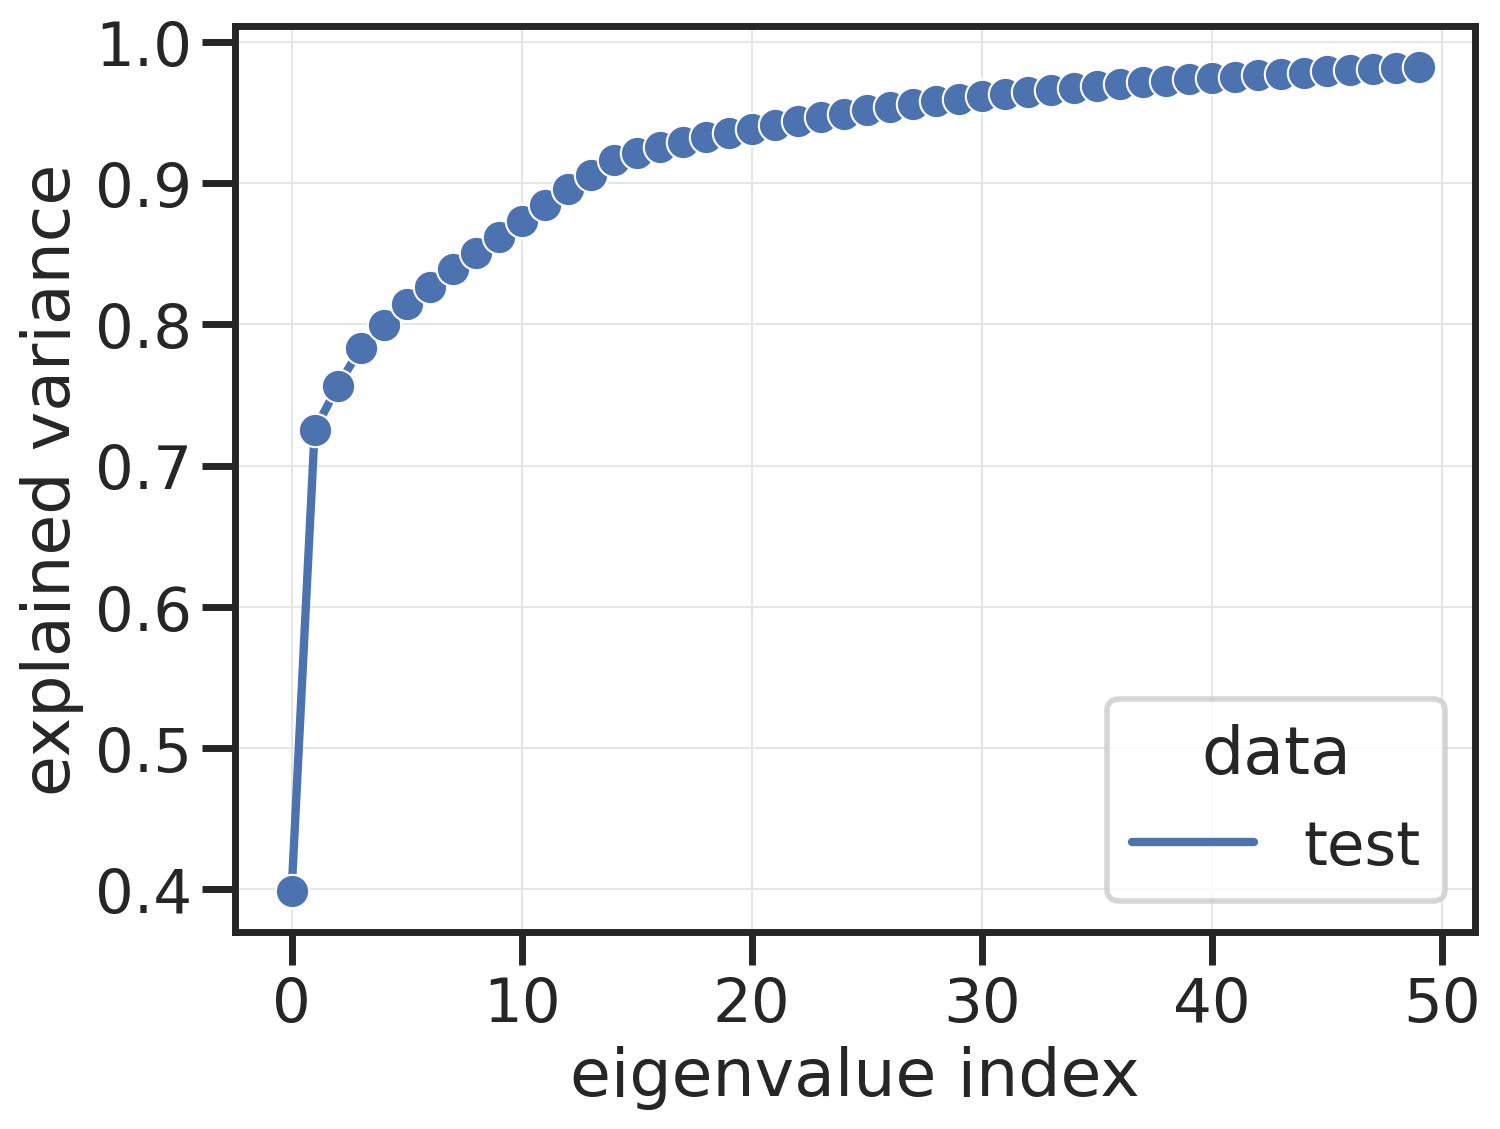

In [125]:
df = get_explained_var(r, key='yvh')
f=plt.figure(figsize=(8,6))
g=sns.lineplot(data=df, x='eigenvalue index', y='explained variance', hue='data', marker="o")

In [ ]:
df = pd.DataFrame()
for key in ['yh', 'yvh']:
    r = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/r_{key}_all.p")
    df_ = get_explained_var(r, key)
    df = pd.concat([df, df_]).reset_index(drop=True)

In [ ]:
f=plt.figure(figsize=(8,6))
g=sns.lineplot(data=df, x='eigenvalue index', y='explained variance', hue='data', marker="o")

In [ ]:
f.savefig('plots/explained_var.pdf')

### Embed at a certain error level

In [134]:
key = 'yh'
fn = 'all_geod'
r = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/r_{key}_{fn}.p")
# didx = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_{key}_{fn}.p").reset_index(drop=True)
didx = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p').reset_index(drop=True)
# didx = didx.drop('index', axis=1)

In [135]:
ii = get_idx(didx, "(err>0.5 and err<0.51) or (m=='geodesic' and t>0.5 and t <0.51)")
with h5py.File("/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all_geod.h5", "r") as f:
    w = f["w"]
    wi = w[ii, :][:, ii]
    di = didx.iloc[ii].reset_index(drop=True)

In [136]:
from embed import proj_
l = np.eye(wi.shape[0]) - 1.0/wi.shape[0]
w = -l @ wi @ l / 2
r = proj_(w, w.shape[0], 9)

Projecting


In [137]:
import scipy.sparse.linalg as sp
ne = 50
es, vs = sp.eigsh(w, ne, which='LM', return_eigenvectors=True)
r['es'] = es
r['fn'] = np.linalg.norm(w, 'fro')

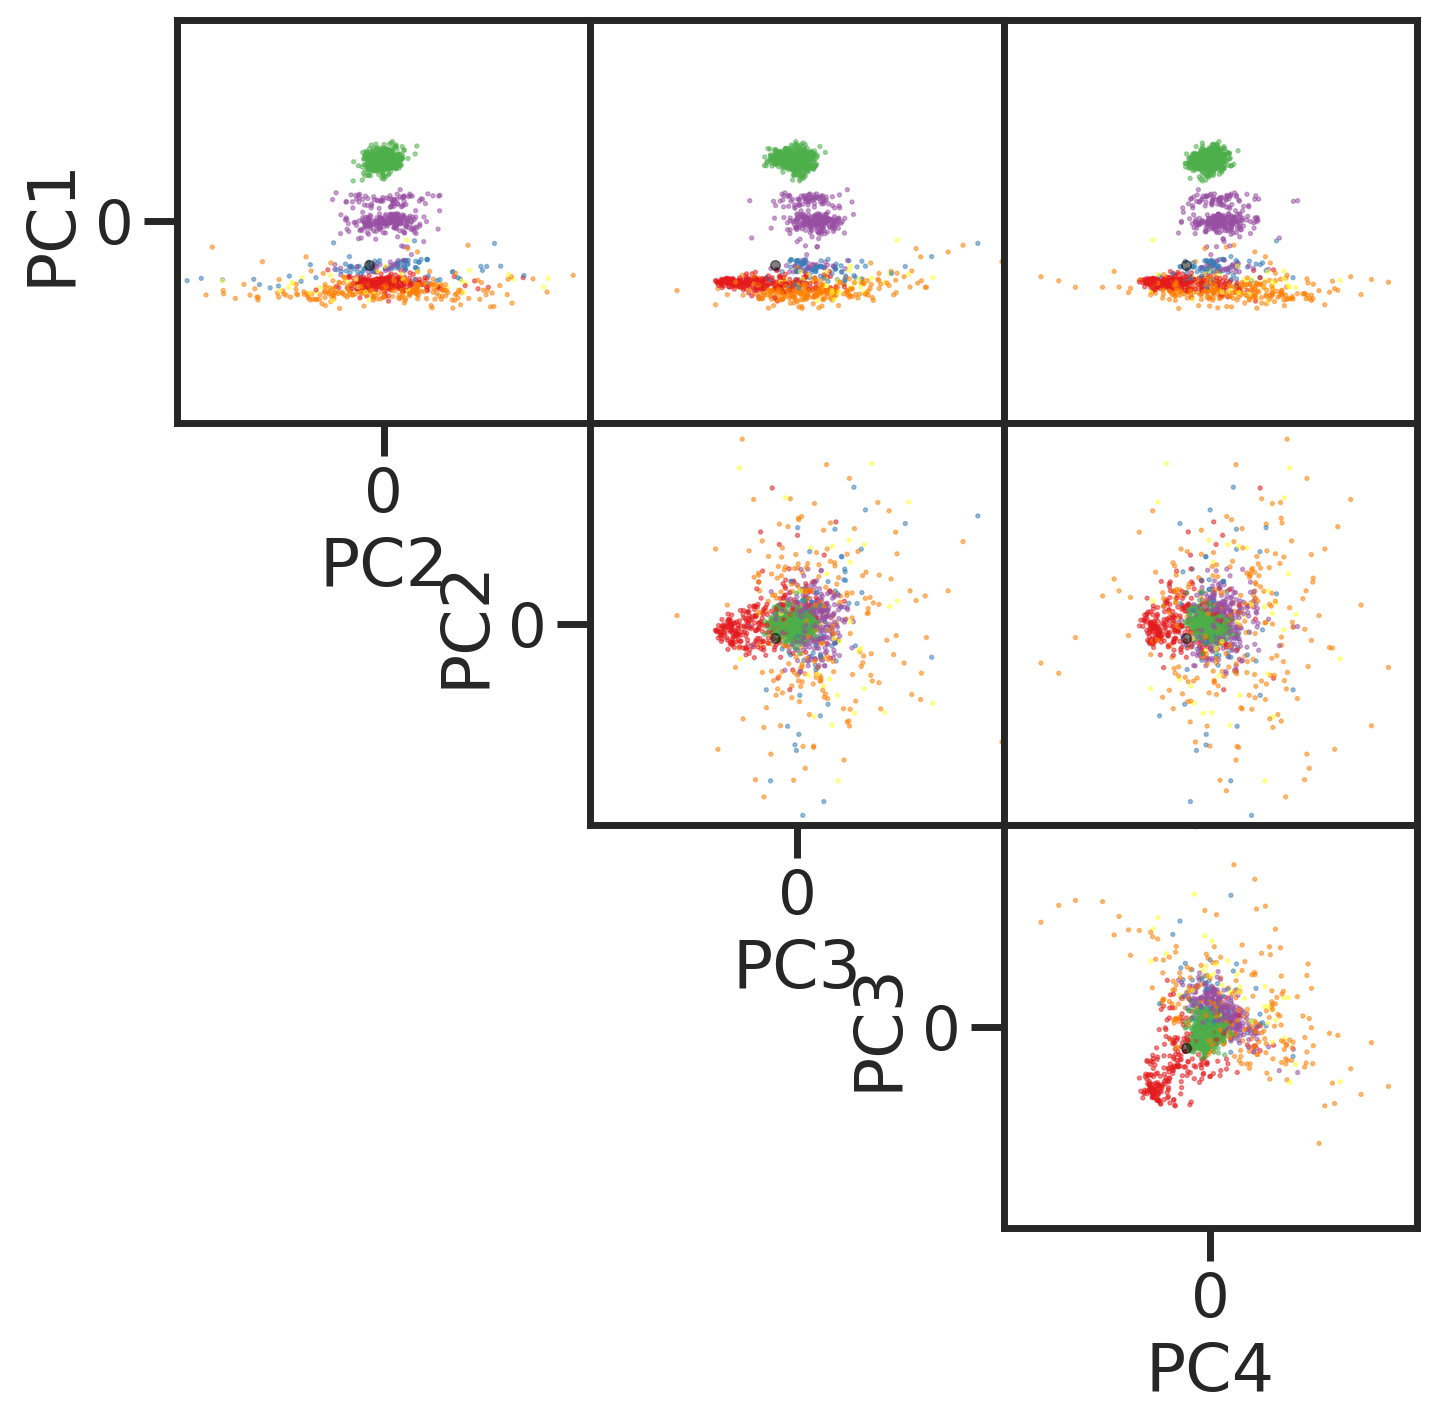

In [140]:
from utils import triplot
n=4
emph = list(di[di.m=='geodesic'].index)
f, gs = triplot(di.reset_index(drop=True), r, emph={'geodesic':emph},
                    empsize={'geodesic':12}, 
                    empcolor={'geodesic':'black'}, d=n, 
                ckey='m', colorscale='Set1',
                grid_ratio=[4]*n, grid_size=0.1, centers=[0]*n)

In [ ]:
fig = plotly_3d(dc=di, r=r, 
                    opacity=0.25,
                    colorscale='Set1',
                    ne=5, 
                    color='m',
                    cols = ['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
                    xrange=[-1, 1],
                    yrange=[-0.75, 1.25],
                    zrange=[-0.75, 0.5]
               )
fig.show()

### Understanding outliers

In [36]:
fn='yh_all_geod'
r = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/r_{fn}.p")
didx = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p").reset_index(drop=True)
# didx = didx.drop('index', axis=1)

# adding number of epochs to didx
for (config, ii) in didx.groupby(['seed', 'm', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    if config[1] == 'geodesic':
        continue
    tmax = didx.iloc[ii]['t'].max()
    didx.loc[ii, 'nepochs'] = didx.loc[ii, 't'] * didx.loc[ii, 'bs'].astype(float) / 50000

# adding distance to truch/init to didx
with h5py.File(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/w_{fn}.h5", "r") as f:
    w = f["w"]
    d2truth = w[-1, :][list(didx.index)]
    d2truth[d2truth > 2] = 2
    d2init = w[-100, :][list(didx.index)]
didx['d2truth'] = d2truth
didx['d2init'] = d2init

In [58]:
didx['acc'] = 1-didx['err']
didx['color'] = didx['acc'] - didx['lam_yh']

In [19]:
d_out = didx[didx.color < -0.1].reset_index()

In [49]:
d_out = didx[didx.favg >= 5].reset_index()

In [80]:
d_out=d_out.rename(columns={'Architecture': 'Model Architecture', 'count': 'Count'})

In [51]:
bins = np.array([0, 5, 10, 15, 25, 50, 75, 100, 150])
ind = np.digitize(d_out['nepochs'], bins)
d_out['nepochs_binned'] = bins[ind-1]

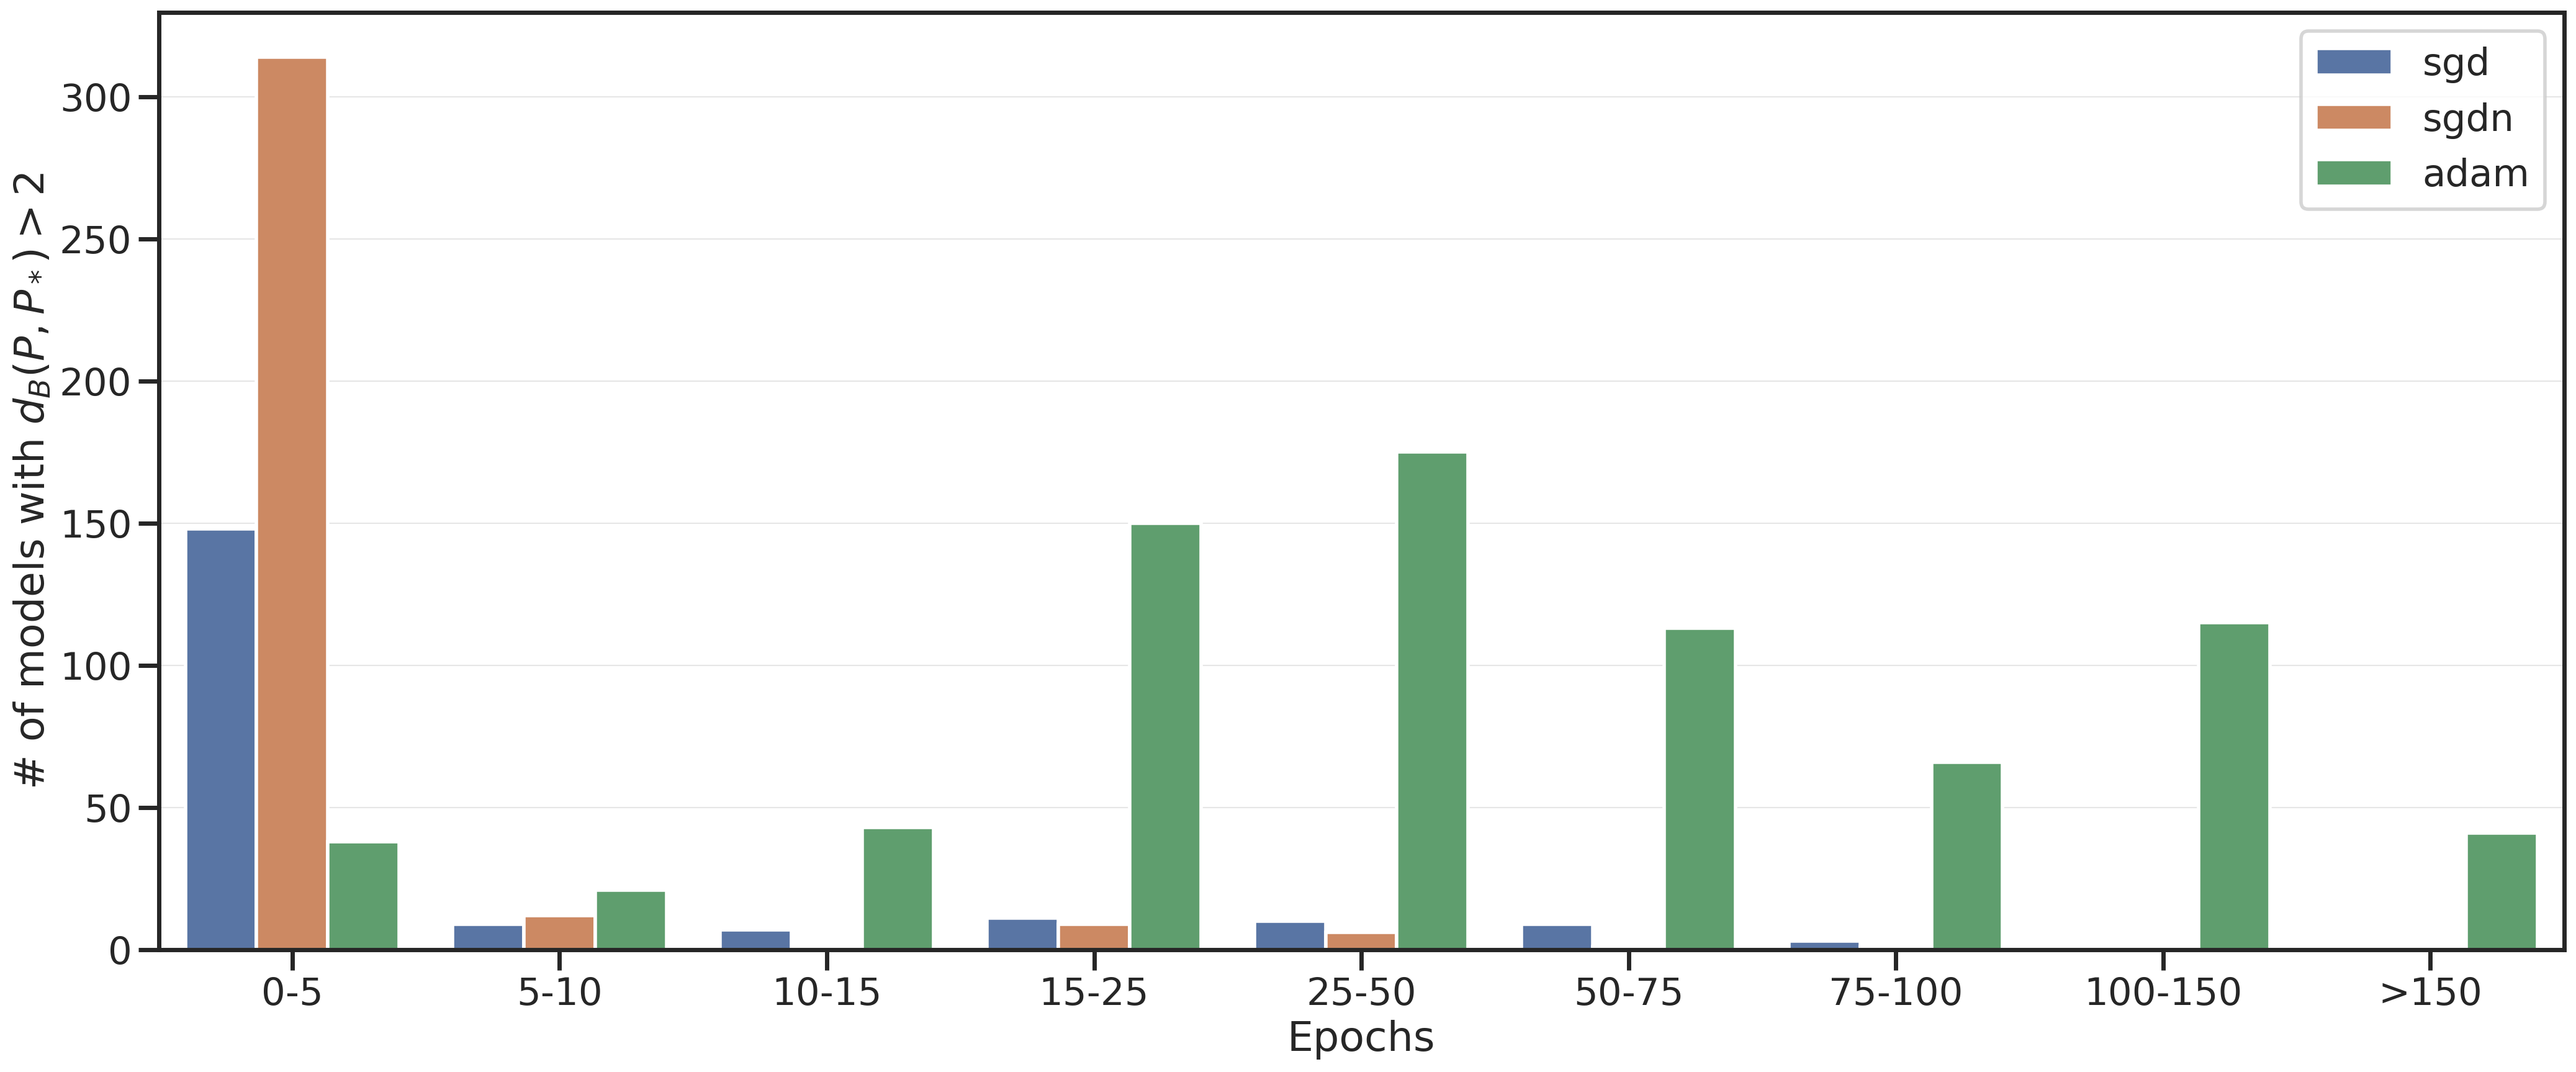

In [52]:
f = plt.figure(figsize=(25, 10))
ax = sns.countplot(data=d_out, x='nepochs_binned', hue='opt')
ax.legend(loc='upper right')
ax.set(ylabel='# of models with $d_B(P, P_*)>2$')
ax.set(xlabel='Epochs')
new_ticks = [i.get_text() for i in ax.get_xticklabels()]
new_ticks = ['-'.join(new_ticks[i:i+2]) for i in range(len(new_ticks)-1)] + ['>150']
ticks = ax.set_xticks(np.arange(0, len(new_ticks)),new_ticks)

In [184]:
f.savefig('plots/all_models_train_by_m.pdf', bbox_inches='tight')

In [ ]:
all_count = 0
cc = 0
with h5py.File(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/w_{fn}.h5", "r") as f:
    w = f["w"]
    for i in tqdm.tqdm(range(len(w))):
        for j in range(i):
            cc += (w[i,j] > w[i,:] + w[:,j]).sum()
            all_count += 1

In [36]:
cols = ['seed', 'm', 'opt', 'bs', 'aug', 'bn', 'lr', 'wd']
configs = []
for (i, r) in d_out.iterrows():
    configs.append(tuple(r[cols]))

In [47]:
idxs = d_out.groupby(cols).indices
idxs = [i for i in idxs.values() if len(i) > 10]

In [72]:
cols = ['seed', 'm', 'opt', 'bs', 'aug', 'bn', 'lr', 'wd']
idxs = didx.groupby(cols).indices

In [120]:
configs = set()
d_out_idxs = []
for (i, d) in d_out.iterrows():
    d[cols[1:]] = d[cols[1:]].astype(str)
    end_err = didx.iloc[idxs[tuple(d[cols])][-1]].err
    end_verr = didx.iloc[idxs[tuple(d[cols])][-1]].verr
    d_out.loc[i, 'end_err'] = end_err
    d_out.loc[i, 'end_verr'] = end_verr
    if didx.iloc[idxs[tuple(d[cols])][-1]].err > 0.1:
        configs.add(tuple(d[cols]))
        d_out_idxs.append(i)

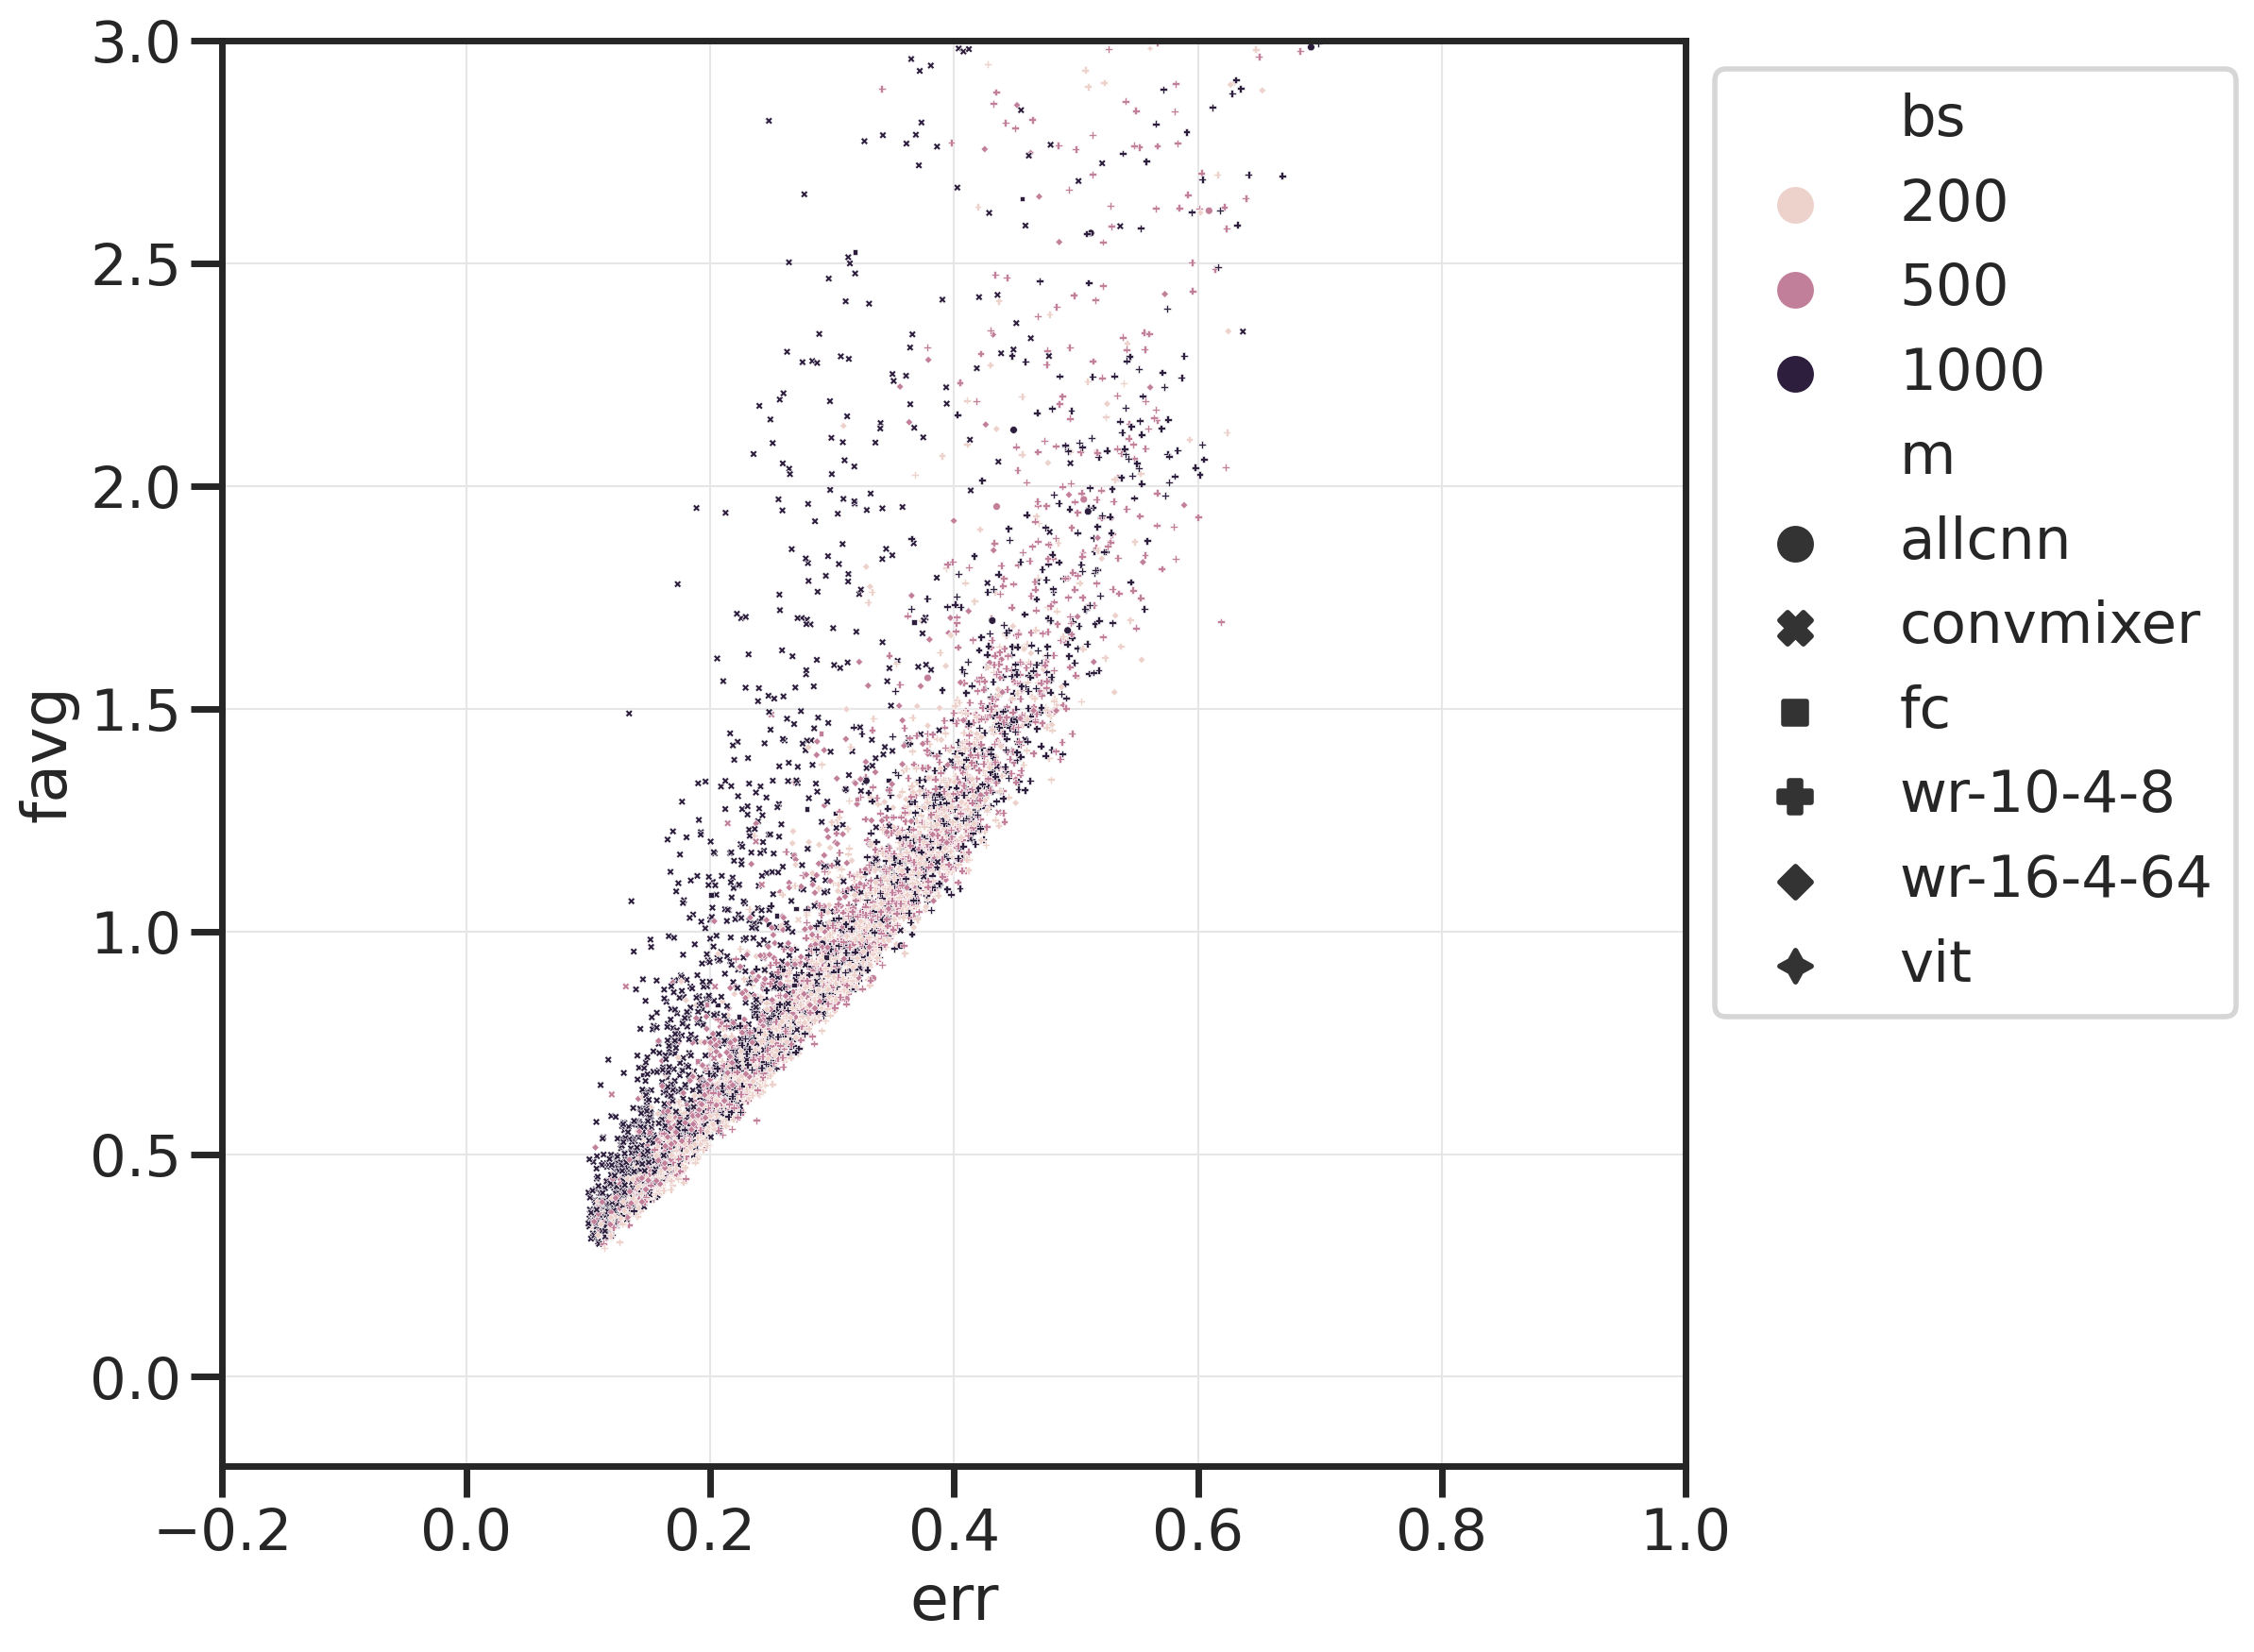

In [43]:
f, ax = plt.subplots()
sns.scatterplot(data=d_out, x='err', y='favg', hue='bs', style='m',s=8, ax=ax)
ax.set(xlim=[-0.2,1], ylim=[-0.2,3])
# ax.set(yscale='log')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
f.savefig('plots/end_err.pdf')

In [ ]:
d_out = d_out.iloc[d_out_idxs].reset_index(drop=True)
dout_idxs = d_out.groupby(cols).indices

In [ ]:
fig = go.Figure()
colors = list(CDICT_M.values())
for (i, c) in enumerate(configs):
    ii = idxs[c]
    dout_ii = dout_idxs[c]
    c = [str(ci) for ci in c]
    fig.add_trace(go.Scatter(x=didx.iloc[ii].nepochs, y=didx.iloc[ii].err,
                    mode='lines',line=dict(width=0.5, color=colors[i%len(colors)])))
    fig.add_trace(go.Scatter(
        x=d_out.iloc[dout_ii].nepochs, y=d_out.iloc[dout_ii].err, mode='markers', 
        marker=dict(color=colors[i%len(colors)], size=4)
    ))
# fig.update_xaxes(type="log")
fig.show()

In [ ]:
fig = go.Figure()

for c in configs:
    ii = idxs[c]
    c = [str(ci) for ci in c]
    fig.add_trace(
            go.Scatter3d(
                x=r['xp'][ii, 0],
                y=r['xp'][ii, 1],
                z=r['xp'][ii, 2],
                marker=dict(
                    size=2,
                    opacity=0.5,
                    color=didx.iloc[ii].nepochs,
                    colorscale='RdBu'
                ),
                mode='lines+markers',
                showlegend=True,
            )
        )
fig.add_trace(
                go.Scatter3d(
                x=r['xp'][-100:, 0],
                y=r['xp'][-100:, 1],
                z=r['xp'][-100:, 2],
                marker=dict(
                    size=2,
                    opacity=0.5,
                    color='black',
                ),
                mode='markers',
                showlegend=True,
))
fig.show()

In [ ]:
cols =  ['nepochs', 'opt']
c = d_out.groupby(cols).count()[['seed']]
c = c.reset_index()

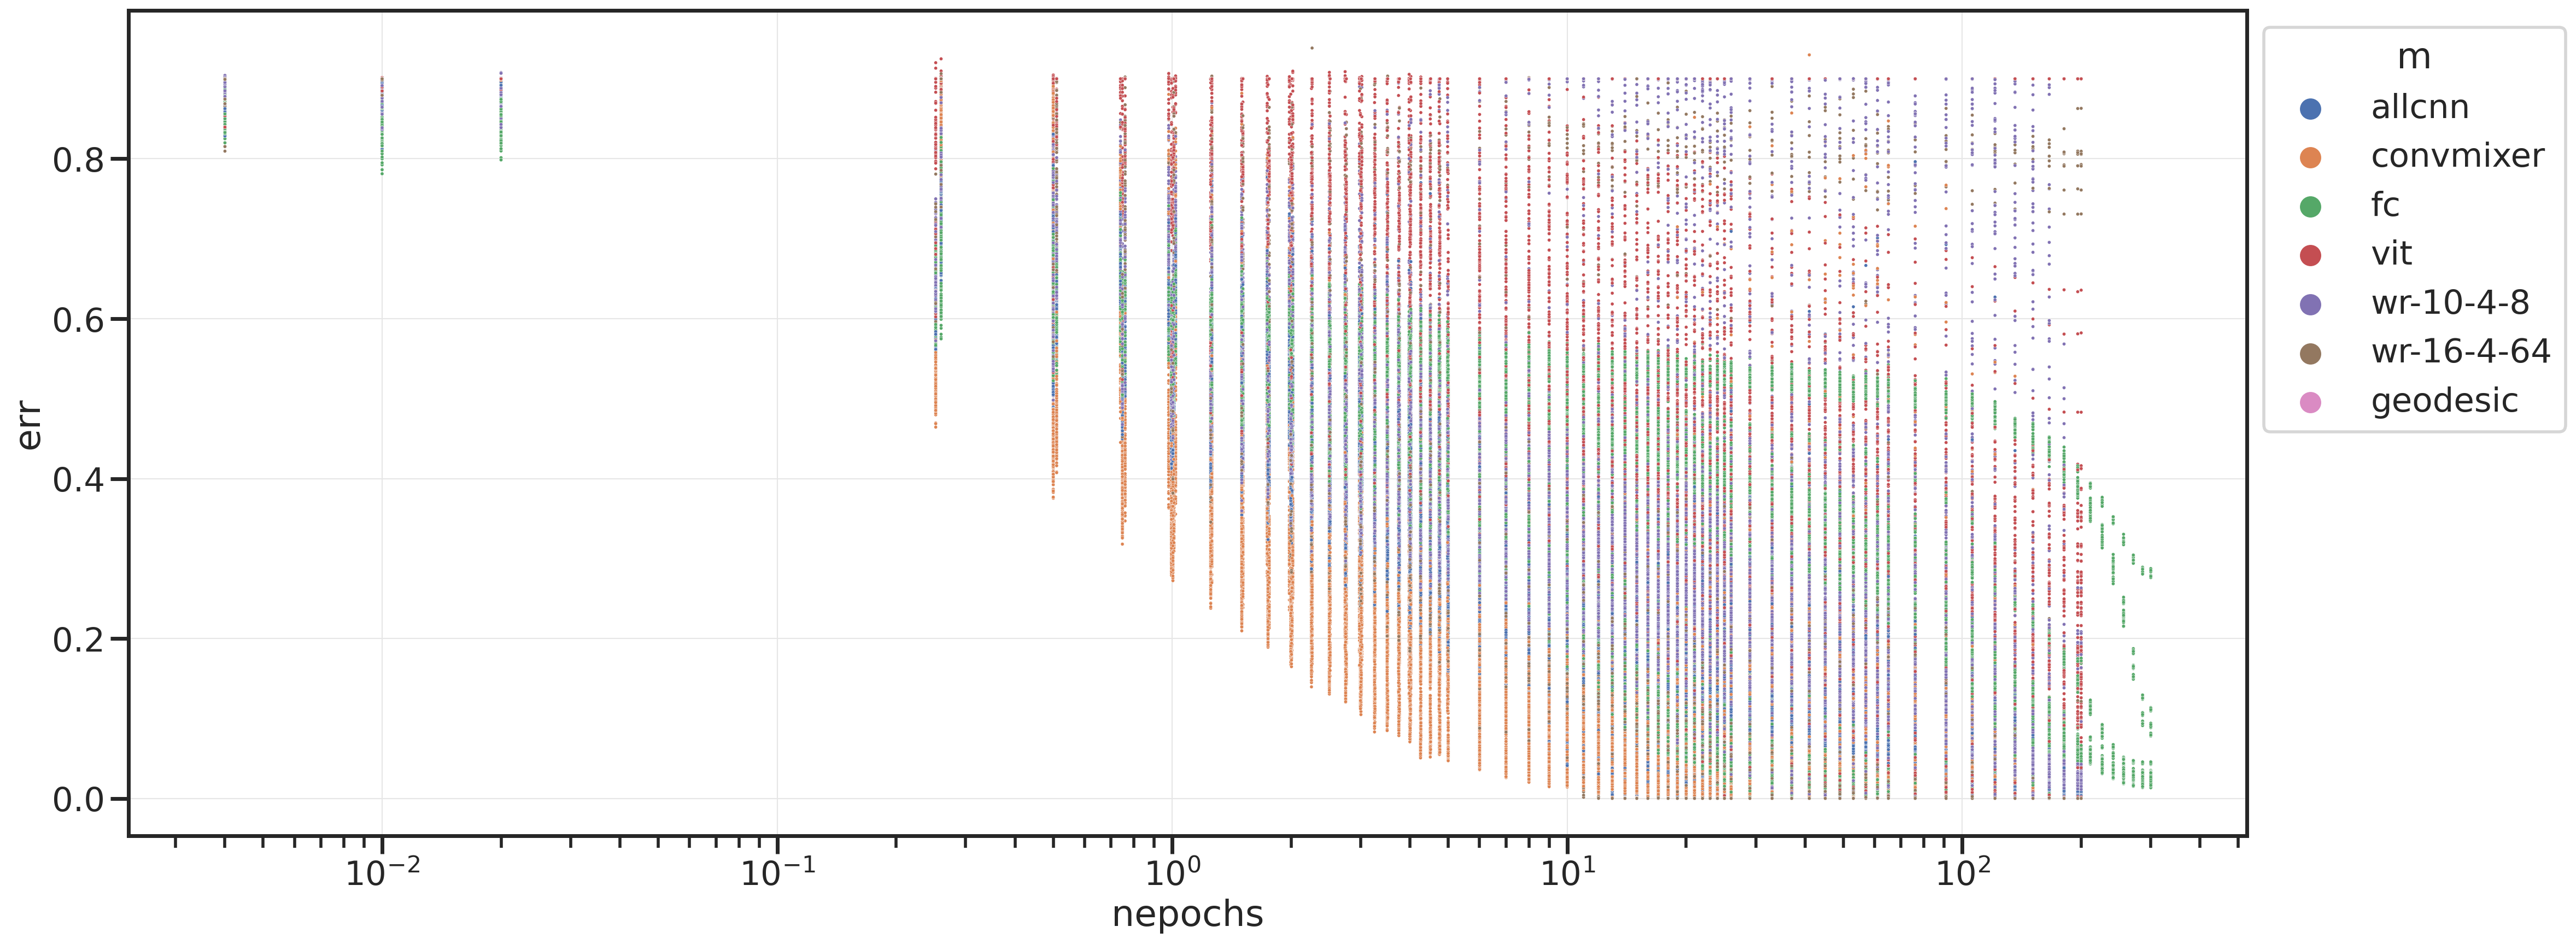

In [130]:
plt.figure(figsize=(25, 10))
ax=sns.scatterplot(data=didx, x='nepochs', y='err', hue='m', s=5)
ax.set(xscale='log')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

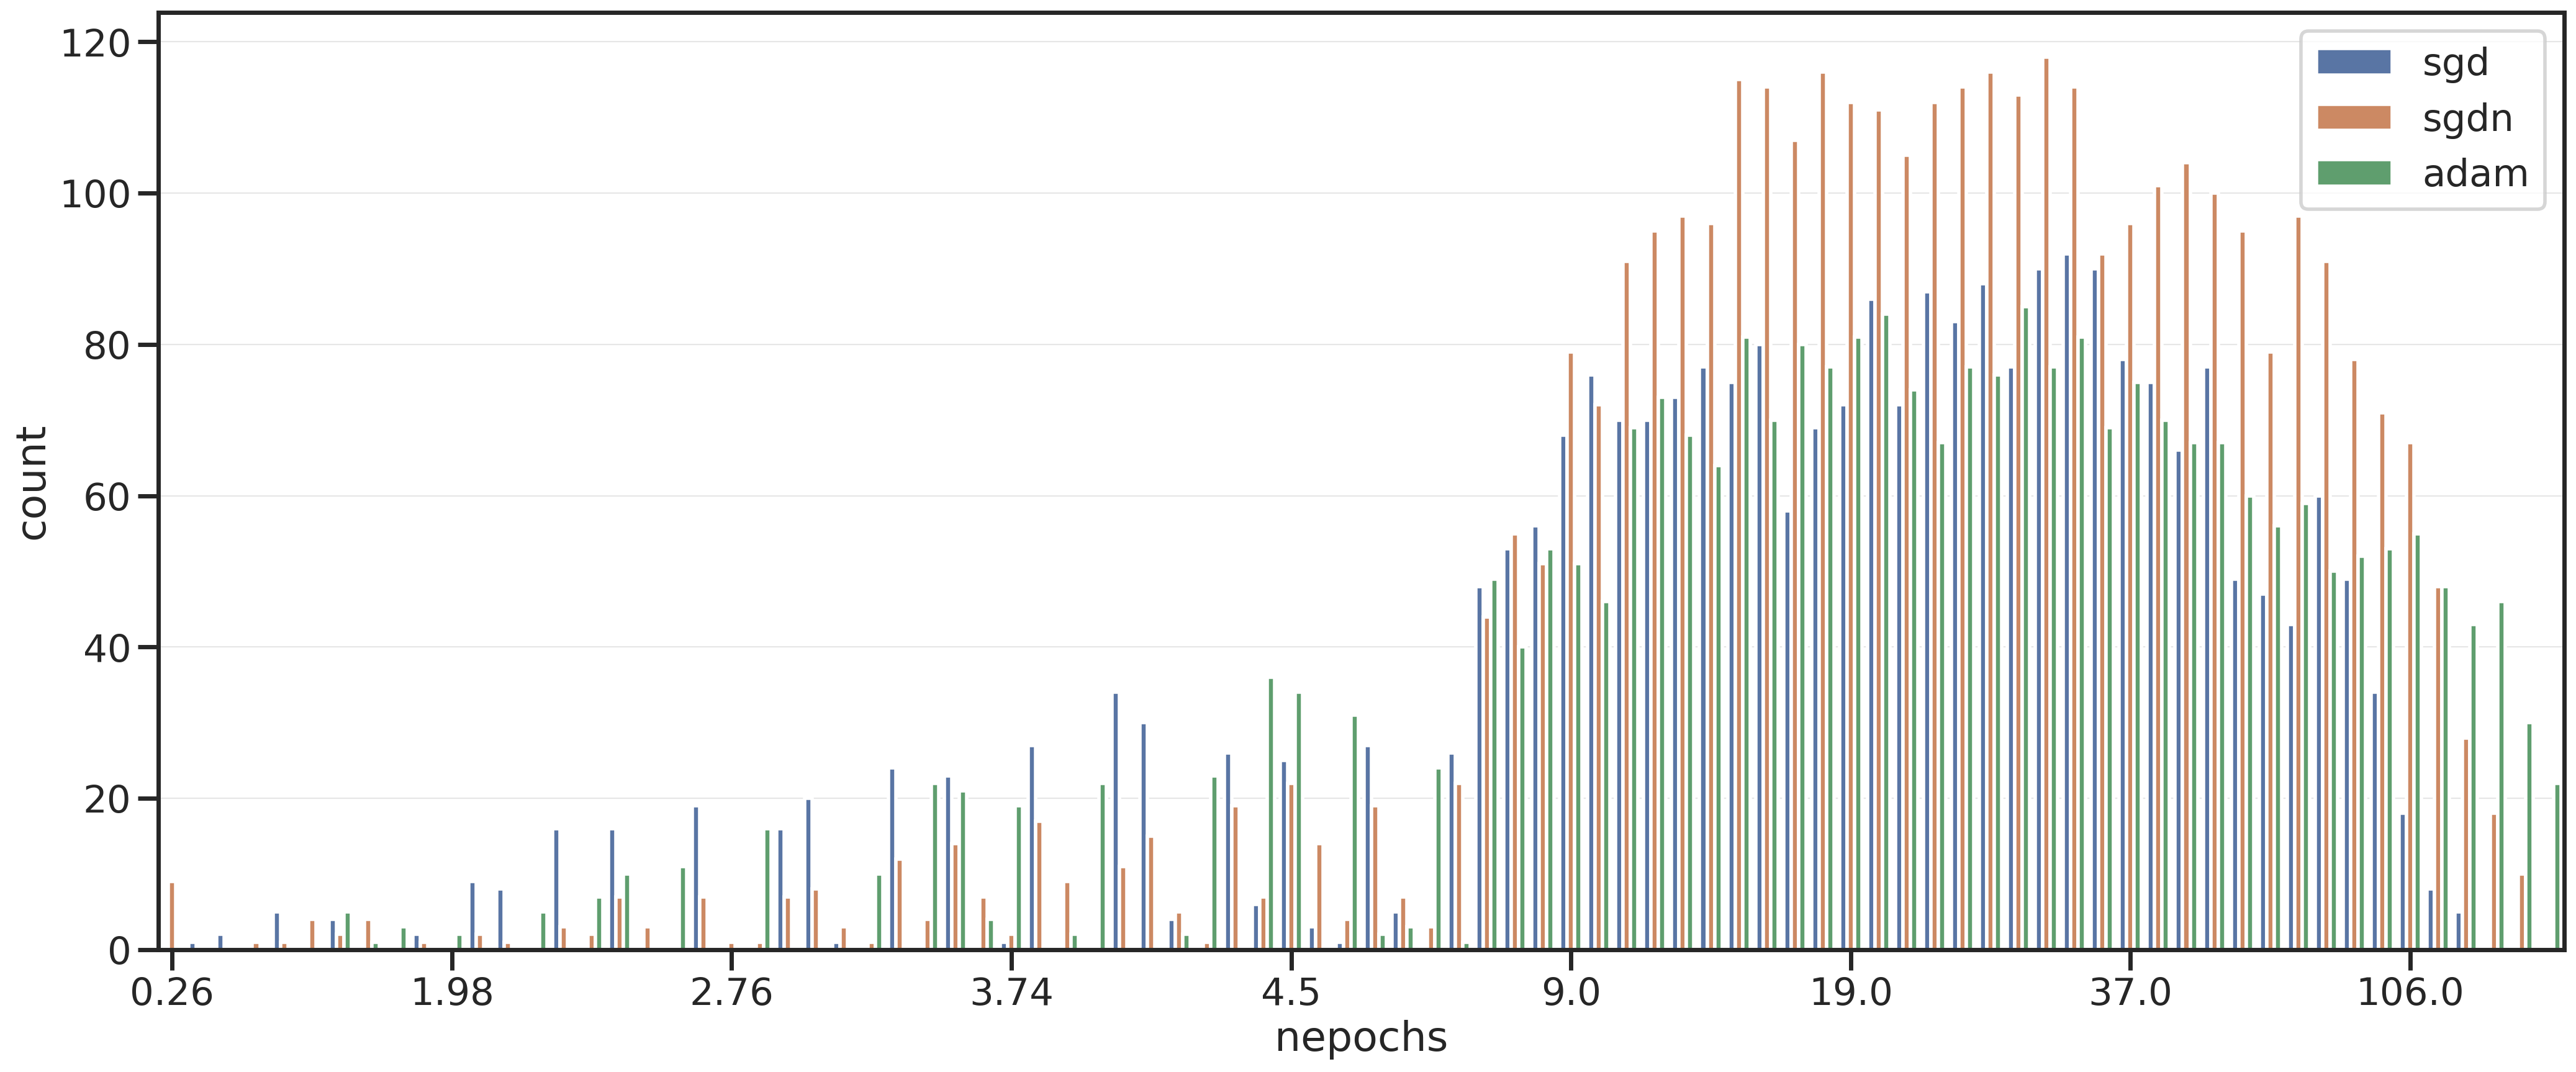

In [114]:
plt.figure(figsize=(25, 10))
ax = sns.countplot(data=d_out, x='nepochs', hue='opt')
ax.legend(loc='upper right')
new_ticks = [i.get_text() for i in ax.get_xticklabels()]
ticks = ax.set_xticks(range(0, len(new_ticks), 10), new_ticks[::10])

### Mean Trajectories in InPCA coordinates

In [114]:
key = 'yh'
fn = 'all_geod'
r = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/r_{key}_{fn}.p")
didx = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p").reset_index(drop=True)
# didx = didx.drop('index', axis=1)

# adding number of epochs to didx
for (config, ii) in didx.groupby(['seed', 'm', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    if config[1] == 'geodesic':
        continue
    tmax = didx.iloc[ii]['t'].max()
    didx.loc[ii, 'nepochs'] = didx.loc[ii, 't'] * didx.loc[ii, 'bs'].astype(float) / 50000

# adding distance to truch/init to didx
import h5py
with h5py.File(f"/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all_geod.h5", "r") as f:
    w = f["w"]
    d2truth = w[-1, :][list(didx.index)]
    d2truth[d2truth > 2] = 2
    d2init = w[-100, :][list(didx.index)]
didx['d2truth'] = d2truth
didx['d2init'] = d2init

In [115]:
# adding number of epochs to didx
trained_ii = []
for (config, ii) in didx.groupby(['seed', 'm', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    if didx.iloc[ii[-1]].err > 0.1:
        continue
    trained_ii.extend(ii)

In [116]:
didx_avg = didx.iloc[trained_ii].reset_index(drop=True)
xp_avg = r['xp'][trained_ii, :]

t = np.linspace(0, 1.0, 100)
# theta=1/np.sqrt(10)
# didx_avg.loc[:99, 'vfavg'] = np.sin((1-t)*np.arccos(theta)) / (np.sin(np.arccos(theta)) * np.cos(theta)) + np.sin(t*theta) /np.sin(theta)
# didx_avg['vfavg'] = np.clip(didx_avg['vfavg'].values, 0,3)
# bins =  np.linspace(0, 3,100)
# ind = np.digitize(didx_avg['vfavg'], bins)
# didx_avg[f'lam_{key}_int'] = bins[ind-1]

didx_avg.loc[:99, f'lam_yh'] = didx_avg.iloc[:100]['t']
bins = np.array(list(np.arange(0, 0.5, 0.1))+list(np.arange(0.5, 1, 0.05)) + [0.99])
ind = np.digitize(didx_avg[f'lam_yh'], bins)
didx_avg[f'lam_{key}_int'] = bins[ind-1]

# didx_avg.loc[:99, 'err'] = 0
# bins =  np.arange(0, 1.0, 0.01)
# ind = np.digitize(didx_avg['err'], bins)
# didx_avg[f'lam_{key}_int'] = bins[ind-1]

ii = didx_avg[didx_avg.d2truth<2].index
davg = didx_avg.iloc[ii].reset_index(drop=True)
xpavg = xp_avg[ii, :]

In [117]:
xm = []
xstd = []
mt = []
# cols = ['m', 'opt', 'wd']
cols=['m']
tgroup = [f'lam_{key}_int']
# tgroup = ['favg_int']
# tgroup = ['err_int']
# tgroup=['nepochs']
for (t, ti) in davg.groupby(cols+tgroup).indices.items():
    mt.append(t)
    xm.append(xpavg[ti, :].mean(0))
    xstd.append(xpavg[ti, :].std(0).astype(str))

In [118]:
xm = pd.DataFrame(xm, columns=[f'x{i}' for i in range(7)])

mt = np.array(mt)
xm[cols+['t']] = mt
xm['t'] = xm['t'].astype(str)

xstd = np.array(xstd)
xm['std'] = xstd.astype(float).max(axis=1).astype(str)

In [119]:
xm['std'].astype(float).mean(), xm['std'].astype(float).std()

(0.04947624042410715, 0.034516290819093395)

In [59]:
def project_points(points, camera_position, camera_angle):
    """
    Project a list of 3D points onto a 2D plane defined by a camera position and angle.
    
    Arguments:
    points -- a list of 3D points to be projected, shape (n, 3)
    camera_position -- the position of the camera in 3D space, shape (3,)
    camera_angle -- the rotation angles of the camera around the x, y, and z axes in radians, shape (3,)
    
    Returns:
    projected_points -- a list of 2D points representing the projection of the input points onto the 2D plane, shape (n, 2)
    """
    
    # Construct a rotation matrix from the camera angles
    R_x = np.array([[1, 0, 0], [0, np.cos(camera_angle[0]), -np.sin(camera_angle[0])], [0, np.sin(camera_angle[0]), np.cos(camera_angle[0])]])
    R_y = np.array([[np.cos(camera_angle[1]), 0, np.sin(camera_angle[1])], [0, 1, 0], [-np.sin(camera_angle[1]), 0, np.cos(camera_angle[1])]])
    R_z = np.array([[np.cos(camera_angle[2]), -np.sin(camera_angle[2]), 0], [np.sin(camera_angle[2]), np.cos(camera_angle[2]), 0], [0, 0, 1]])
    R = R_z @ R_y @ R_x
    
    # Translate the points to be relative to the camera position
    t = -np.array(camera_position)
    points_t = points + t
    
    # Rotate the points relative to the camera orientation
    points_r = np.dot(points_t, R)
    
    # Project the rotated points onto the 2D plane
    projected_points = points_r[:, :2] / points_r[:, 2, np.newaxis]
    
    return projected_points

In [ ]:
camera_position = [1, -0.5, 1.5] 
camera_angle = [-np.pi/4, -np.pi/4, -np.pi/2]
xy = project_points(np.stack(xm[['x0', 'x1', 'x2']].values), camera_position, camera_angle)
xm[['xx1', 'xx2']] = xy
fig=px.line(xm, x='xx1', y='xx2', color='m')
fig.update_layout(
        autosize=False,
        width=1000,
        height=1000,
        scene_xaxis_range=[1,2],
        scene_yaxis_range=[-0.75,1.25],
    scene_aspectratio={
            'x': 1,
            'y': 1,
        },
 template='plotly_white')
fig.show()

In [ ]:
fig = go.Figure()
for (c, ii) in xm.groupby(cols).indices.items():
    xxm = xm.iloc[ii]
    c = [c] if isinstance(c, str) else c
    fig.add_trace(
        go.Scatter3d(
            x = xxm.x0, 
            y = xxm.x1,
            z = xxm.x2,
            marker=dict(
                size=5,
                color=xxm['std'].astype(float),
#                     color=CDICT_M[m],
                colorscale='RdBu',
                coloraxis = "coloraxis", 
            ),
            mode='lines',
            
            line=dict(
                width=4,
                color=CDICT_M[c[0]],
            ),
            
            text=xxm[['std', 't']].apply('-'.join, axis=1),
            name='-'.join(c),
        ), 
    )
fig.update_layout(
        autosize=False,
        width=1000,
        height=1000,
        scene_xaxis_range=[-1,1],
        scene_yaxis_range=[-0.75,1.25],
        scene_zaxis_range=[-1,1],
        scene_aspectratio={
            'x': 1,
            'y': 1,
            'z': 1,
        },
 template='plotly_white',)
fig.show()

In [ ]:
fig = go.Figure()
for (c, ii) in xm.groupby(cols).indices.items():
    xxm = xm.iloc[ii]
    c = [c] if isinstance(c, str) else c
    fig.add_trace(
        go.Scatter3d(
            x = xxm.x0, 
            y = xxm.x1,
            z = xxm.x2,
            marker=dict(
                size=5,
                color=xxm['std'].astype(float),
#                     color=CDICT_M[m],
                colorscale='RdBu',
                coloraxis = "coloraxis", 
            ),
            mode='lines',
            
            line=dict(
                width=4,
                color=CDICT_M[c[0]],
            ),
            
            text=xxm[['std', 't']].apply('-'.join, axis=1),
            name='-'.join(c),
        ), 
    )
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    scene_xaxis_range=[-1,1],
    scene_yaxis_range=[-1,1],
    scene_zaxis_range=[-1,1])
fig.show()

In [ ]:
fig = go.Figure()
for (c, ii) in xm.groupby(cols).indices.items():
    xxm = xm.iloc[ii]
    c = [c] if isinstance(c, str) else c
    fig.add_trace(
        go.Scatter3d(
            x = xxm.x0, 
            y = xxm.x1,
            z = xxm.x2,
#             marker=dict(
#                 size=5,
#                     color=xxm['t'].astype(float),
# #                     color=CDICT_M[m],
#                 coloraxis = "coloraxis", 
#             ),
            mode='lines',
            line=dict(
                width=4,
                color=CDICT_M[c[0]],
            ),
            
            text=xxm[['std', 't']].apply('-'.join, axis=1),
            name='-'.join(c),
        ), 
    )
fig.show()

In [ ]:
fig = go.Figure()
# ts = np.array(list(np.linspace(0.1, 1, 10)) + list(np.linspace(0.9, 0.99, 10)[::2]))
# it = xm[xm.t.isin(ts.astype(str))].index
# xm = xm.iloc[it].reset_index(drop=True)
for (c, ii) in xm.groupby(cols).indices.items():
    xxm = xm.iloc[ii]
    c = [c] if isinstance(c, str) else c
    fig.add_trace(
        go.Scatter3d(
            x = xxm.x0, 
            y = xxm.x1,
            z = xxm.x2,
#             marker=dict(
#                 size=5,
#                     color=xxm['std'].astype(float),
# #                     color=CDICT_M[m],
#                 coloraxis = "coloraxis"
#             ),
            mode='lines',
            line=dict(
                width=4,
                color=CDICT_M[c[0]],
            ),
            
            text=xxm[['std']].apply('-'.join, axis=1),
            name='-'.join(c)
        ), 
    )
    

fig.update_layout(
autosize=False,
width=800,
height=800,
scene_xaxis_range=[-0.75, 0.7],
scene_yaxis_range=[-0.45, 0.75],
scene_zaxis_range=[-0.5, 0.3],
template='plotly_white',
coloraxis = {'colorscale':'RdBu', 'showscale':False},
scene_xaxis_linecolor='black',
    scene_xaxis_linewidth=4.5,
    scene_yaxis_linewidth=4.5,
    scene_zaxis_linewidth=4.5,
scene_yaxis_linecolor='red',
scene_zaxis_linecolor='black',
scene_aspectratio={
'x': 1.45,
'y': 1.2,
'z': 0.8,
},
)
annotations=[]
# annotations=[
#     dict(
#         x=0.4, y=-0.2, z=0.1,
#         text="Geodesic",
#         showarrow=False,
#     ),
#     dict(
#     x=-0.3, y=-0.05, z=0.2,
#     text='AllCNN',
#     font_color=CDICT_M['allcnn'],
#     showarrow=False,
#     ),
#     dict(
#         x=-0.25, y=0.15, z=0.1,
#         text='Fully Connected',
#         font_color=CDICT_M['fc'],
#         showarrow=False,
#     ),
#     dict(
#     x=-0.27, y=0.35, z=0.1,
#     text='ViT',
#     font_color=CDICT_M['vit'],
#     showarrow=False,
#     ),
#     dict(
#     x=-0.15, y=0.1, z=0.1,
#     text='Small ResNet',
#     font_color=CDICT_M['wr-10-4-8'],
#     showarrow=False,
#     ),
#     dict(
#     x=0, y=0.1, z=0.1,
#     text='Large ResNet',
#     font_color=CDICT_M['wr-16-4-64'],
#     showarrow=False,
#     ),
#     dict(
#     x=0.4, y=-0.2, z=-0.2,
#     text='P0',
#     font_color='red',
#     font_size=22,
#     showarrow=False,
#     ),
#     dict(
#         x=-0.75, y=0.75, z=-0.2,
#         text='P*',
#         font_color='red',
#         font_size=22,
#         showarrow=False,
#     )
# ]
camera = dict(
    up=dict(x=-0.25, y=-0.1, z=1),
    center=dict(x=0, y=0.0, z=-0.4),
    eye=dict(x=1.25, y=0.65, z=2.15)
)
fig.update_layout(scene_camera=camera, showlegend=False, scene_annotations=annotations)
fig.show()


### Reindexed Models

In [ ]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/r_yh_all.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/didx_all.p").reset_index(drop=True)

In [ ]:
import h5py
f = h5py.File('/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/w_yh_all.h5', 'r')
w = f['w']

In [ ]:
from embed import proj_
l = np.eye(w.shape[0]) - 1.0/w.shape[0]
w = -l @ w @ l / 2
r = proj_(w, w.shape[0], 3)

In [ ]:
th.save(r, '/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/r_yh_all.p')

In [ ]:
fig = plotly_3d(dc=didx.reset_index(drop=True), r=r, 
                    opacity=0.25,
                    colorscale='Set1',
                    ne=5, return_d=True,
                    color='m',mode='markers', 
                    xrange=[-0.75, 0.75],
                    yrange=[-0.75, 0.75],
                    zrange=[-0.75, 0.75])
# fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.5))
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=-0.2, y=0, z=0),
    eye=dict(x=2.55, y=2.65, z=2.85)
)
fig.update_layout(scene_camera=camera)
fig.show()

In [ ]:
f, gs = triplot(didx.reset_index(drop=True), r, d=3, colorscale='vlag', ckey='err',grid_ratio=[4,3,3], grid_size=0.2)

#### Same models in original space

In [ ]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_interp_subset.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_yh_all.p").reset_index(drop=True)

In [ ]:
idxs = get_idx(didx, "aug=='none' & seed <=46")
dd = didx.iloc[idxs].reset_index(drop=True)

In [ ]:
import h5py
from embed import proj_
f = h5py.File('/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all.h5', 'r')
w = f['w']
wi = w[idxs,:][:, idxs]
l = np.eye(wi.shape[0]) - 1.0/wi.shape[0]
wi = -l @ wi @ l / 2
r = proj_(wi, wi.shape[0], 3)

In [ ]:
th.save(r, "/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_interp_subset.p")

In [ ]:
idxs = []
for (config, ii) in dd.groupby(['seed', 'm', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    tmax = dd.iloc[ii]['t'].max()
    dd.loc[ii, 't'] /= tmax

In [ ]:
emph = get_idx(dd, "m=='geodesic'")
triplot(dd.reset_index(drop=True), r, d=3, colorscale='Set1', ckey='m',grid_ratio=[3,3,3], grid_size=0.25)

### Mixed

In [ ]:
didx = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_mixed/didx_yh_subset.p')
r = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_mixed/r_yh_subset.p')

In [ ]:
didx = pd.concat([didx['dr'], didx['dc']]).reset_index(drop=True)

In [ ]:
idxs = []
for (config, ii) in didx.groupby(['seed', 'm', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    tmax = didx.iloc[ii]['t'].max()
    didx.loc[ii, 't'] /= tmax

In [ ]:
didx['interp'] = '1'
didx['interp'].iloc[:7678] = '0'

In [ ]:
f, gs = triplot(didx.reset_index(drop=True), r, d=3, cmap='Set1', ckey='interp',grid_ratio=[3,3,3], grid_size=0.2)

In [ ]:
# emph = list(didx[didx.interp==True].index)
fig = plotly_3d(dc=didx.reset_index(drop=True), r=r, 
                    opacity=0.25,
                    colorscale='Set1',
                    ne=5, return_d=True,
                    color='interp',mode='markers', 
                    xrange=[-0.75, 0.75],
                    yrange=[-0.75, 0.75],
                    zrange=[-0.75, 0.75])
# fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.5))
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=-0.2, y=0, z=0),
    eye=dict(x=2.55, y=2.65, z=2.85)
)
fig.update_layout(scene_camera=camera)
fig.show()

In [ ]:
th.save(r, '/home/ubuntu/ext_vol/inpca/inpca_results_mixed/r_yh_subset.p')

In [ ]:
w = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_mixed/w_yh_(42, False)_(42, True).p')

In [ ]:
import h5py
from embed import proj_
w1 = h5py.File('/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all.h5', 'r')['w']
w1 = w1[idxs,:][:, idxs]

In [ ]:
w2 = h5py.File('/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/w_yh_all.h5', 'r')['w']

### MDS

In [ ]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_euclid.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all.p").reset_index(drop=True)
idxs = get_idx(didx, "(m=='allcnn' and aug == 'simple' and wd==0.0) or m=='geodesic'")
didx = didx.iloc[idxs].reset_index(drop=True)
r['xp'] = r['xp']

In [ ]:

fig = plotly_3d(dc=didx.reset_index(drop=True), r=r, 
                    opacity=0.25,
                    colorscale='rdbu',
                    ne=5, 
                    color='t',
                    xrange=[-1, 0.75],
                    yrange=[-0.75, 0.75],
                    zrange=[-0.75, 0.75])
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=-0.2, y=0, z=0),
    eye=dict(x=2.55, y=2.65, z=2.85)
)
fig.update_layout(scene_camera=camera)
fig.show()

In [ ]:
from sklearn.manifold import MDS
mds = MDS(n_components=3, metric=True, dissimilarity='precomputed')

In [ ]:
import h5py
f = h5py.File(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all_geod.h5', 'r')
w = f['w']

In [ ]:
X_transformed = mds.fit_transform(w[idxs,:][:, idxs])
th.save(X_transformed, "mds_allcnn.p")

In [ ]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all_geod.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all.p").reset_index(drop=True)
idxs = get_idx(didx, "(m=='allcnn' and aug == 'simple' and wd==0.0) or m=='geodesic'")
didx = didx.iloc[idxs].reset_index(drop=True)
r['xp'] = r['xp'][idxs]
X_transformed = th.load('mds_allcnn.p')
r['xp'] = X_transformed

In [ ]:
emph = [list(didx[didx.m=='geodesic'].index)]

fig = plotly_3d(dc=didx.reset_index(drop=True), r=r, 
                    opacity=0.25,
                    colorscale='rdbu',
                    ne=3, 
                    color='t', 
                    xrange=[-1, 0.75],
                    yrange=[-0.75, 0.75],
                    zrange=[-0.75, 0.75])
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=-0.2, y=0, z=0),
    eye=dict(x=2.55, y=2.65, z=2.85)
)

fig.update_layout(scene_camera=camera)
fig.show()

In [ ]:
wi = w[idxs,:][:, idxs]
l = np.eye(wi.shape[0]) - 1.0/wi.shape[0]
wi = -l @ wi @ l / 2

In [ ]:
from embed import proj_
r = proj_(wi, wi.shape[0], 3)

In [ ]:
emph = [list(didx[didx.m=='geodesic'].index)]
fig = plotly_3d(dc=didx.reset_index(drop=True), r=r, 
                    opacity=0.25,
                    colorscale='rdbu',
                    ne=3, return_d=True,
                    color='t',mode='markers', 
                    xrange=[-1, 0.75],
                    yrange=[-0.75, 0.75],
                    zrange=[-0.75, 0.75])
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=-0.2, y=0, z=0),
    eye=dict(x=2.55, y=2.65, z=2.85)
)
fig.update_layout(scene_camera=camera)
fig.show()